In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb 

In [2]:
def convert_values(value):
    if value == 'NA':
        return 0
    else:
        return value

# Data load
## listings

In [3]:
listings_data_types = {'id':'int64', 'host_id':'int32', \
       'latitude':'float32', \
       'longitude':'float32', 'accommodates':np.ubyte,  \
       'availability_30':np.ubyte, 'availability_60':np.ubyte, 'availability_90':np.ubyte, 'availability_365':np.ushort,  'number_of_reviews':np.ushort, \
       'number_of_reviews_ltm':np.ushort, 'number_of_reviews_l30d':np.ubyte,  \
       'review_scores_rating':'float32', 'review_scores_accuracy':'float32', \
       'review_scores_cleanliness':'float32', 'review_scores_checkin':'float32', 'review_scores_communication':'float32', 'review_scores_location':'float32', \
       'review_scores_value':'float32', 'calculated_host_listings_count':np.ushort, \
       'calculated_host_listings_count_entire_homes':np.ushort, 'calculated_host_listings_count_private_rooms':np.ushort, \
        'calculated_host_listings_count_shared_rooms':np.ubyte, 'reviews_per_month':'float32'}

listings = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz", \
                       low_memory=False, \
                       verbose=True, \
                       converters={'bedrooms': convert_values, 'beds': convert_values, 'maximum_nights':convert_values}, \
                       dtype = listings_data_types, \
                       parse_dates=['last_scraped', 'host_since','calendar_updated','calendar_last_scraped', 'first_review', 'last_review'])

Tokenization took: 2482.29 ms
Type conversion took: 1640.11 ms
Parser memory cleanup took: 15.31 ms


## calendar

In [4]:
calendar_data_types = {'listing_id': 'int64', \
    'minimum_nights': np.single, \
    'maximum_nights':'float32'}


calendar = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/calendar.csv.gz", \
                       low_memory=False, \
                       verbose=True, \
                       converters={'adjusted_price': convert_values}, \
                       dtype = calendar_data_types, \
                       parse_dates=['date'])
calendar["date"]=pd.to_datetime(calendar["date"])

Tokenization took: 11693.06 ms
Type conversion took: 9620.35 ms
Parser memory cleanup took: 283.13 ms


## reviews

In [5]:
reviews = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/reviews.csv.gz", \
                      low_memory=False, \
                      verbose=True, \
                      converters={'adjusted_price': convert_values}, \
                      parse_dates=['date'])

Tokenization took: 5576.33 ms
Type conversion took: 3301.36 ms
Parser memory cleanup took: 27.22 ms


# memory optimization
- A regular read_csv for listings implies a memory usage of   50.32MB, but using dtype=listings_data_types   40.09MB:  18.7% reduction

- A regulat read_csv for calendar implies a memory usage of 1714.34MB, but using dtype=calendar_data_types 1469.43MB:  14.3% reduction

  A regulat read_csv for reviews  implies a memory usage of   72.37MB, but using dtype=reviews_data_types ther is not memory save.

I got this figures with 'sum(listings.memory_usage())/1024/1024'

# Ten questions

## 1.- For the compliance department ==> Which percentage of the listings have informed license?

In [6]:
total_listings = listings.shape[0]
grouped= listings.groupby(["license"],group_keys=False)
licenses = grouped.size()
print("Only {:5.4f}% of listings have reported license ".format(100* licenses.iloc[0]/total_listings))

Only 0.0011% of listings have reported license 


## 2.- For the compliance department ==> Which percentage of the listings have a verified host?

In [7]:
total_listings = listings.shape[0]
grouped= listings.groupby(["host_identity_verified"],group_keys=False)
verifications = grouped.size()
print("Only {:5.4f}% of listings have a verified host ".format(100* verifications.iloc[0]/total_listings))

Only 12.6771% of listings have a verified host 


## 3.- For operation department ==> At september time, which is the actual idle capacity for next 365 days?

In [8]:
total_daily_accomodates=listings["accommodates"].sum()
total_year_accomodates = total_daily_accomodates * 365
total_year_available = listings["availability_365"].sum()
idle_capacity = total_year_available / total_daily_accomodates
print("The idle capacity, measured as available accomodates versus total accomodates in 365 days, is {:5.4f}% ".format(idle_capacity))

The idle capacity, measured as available accomodates versus total accomodates in 365 days, is 38.2616% 


## 4.- For Revenue department ==> Which is the average price per accomodate and night in London?

In [9]:
df=listings[["price","availability_365", "accommodates", "minimum_nights", "number_of_reviews", "host_id"]]

In [11]:
# Remove $ 'x[1:]' and thousands comma separator 'replace(",","")' from price column.
df.loc[:,"price_num"] = df["price"].map(lambda x: x[1:].replace(",",""))

In [13]:
df.loc[:,"price_num"]=df["price_num"].apply(pd.to_numeric)
df.loc[:,"price_accomodate"]=df["price_num"]/df["accommodates"]
average_price_accomodate_night =df["price_accomodate"].mean()
print("The Average price per accomodate and night in London is {:5.2f} pounds ".format(average_price_accomodate_night))

The Average price per accomodate and night in London is 64.02 pounds 


## 5.- For Revenue department ==> List host_id for listings with price set to zero.

In [14]:
da = df[["host_id","price_num"]]
mask = da["price_num"] == 0
result = da[mask]["host_id"].unique()
print("There are {} hosts with prices under 10 pounds per accomodate and night. This are their host ids ==> {} . CALL THEM TO CHECK ".format(len(result), list(result)))

There are 1 hosts with prices under 10 pounds per accomodate and night. This are their host ids ==> [3010498] . CALL THEM TO CHECK 


## 6.- For Revenue department ==> List host_id for listings with price per accomodate and night less than ten pounds

In [15]:
da = df[["host_id","price_num"]]
mask = (da["price_num"] > 0) & (da["price_num"] < 10)
result = da[mask]["host_id"].unique()
print("There are {} hosts with prices under 10 pounds per accomodate and night ==> ".format(len(result)), end="")
print(list(result))

There are 14 hosts with prices under 10 pounds per accomodate and night ==> [65184913, 2865823, 157459351, 175198291, 115638835, 122480489, 244699748, 258643139, 96692637, 3010498, 254289088, 296801818, 443134508, 86945986]


## 7.- For Treasury department ==> Forecast weekly income till year-end according to september's known booked listings

In [18]:
# There are 347 prices wiht NA value. I change it by zero.
calendar["price"] =calendar["price"].fillna(0)
# Subset of field required to answer this question
df = calendar[["listing_id", "date", "available", "price"]]
# Remove $ 'x[1:]' and thousands comma separator 'replace(",","")' from price column.
df.loc[:,"price"]=df["price"].map(lambda x: x if isinstance(x, int) else x[1:].replace(",",""))
# convert column to a numeric column
df.loc[:,"price_num"]=df["price"].apply(pd.to_numeric)
# find week fo year 
df.loc[:,"year_week"]= df["date"].dt.isocalendar().week

/tmp/ipykernel_17243/1036559662.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"price_num"]=df["price"].apply(pd.to_numeric)
/tmp/ipykernel_17243/1036559662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"year_week"]= df["date"].dt.isocalendar().week


The accumulated revenue till year-end is 1,111,707,271 GBP


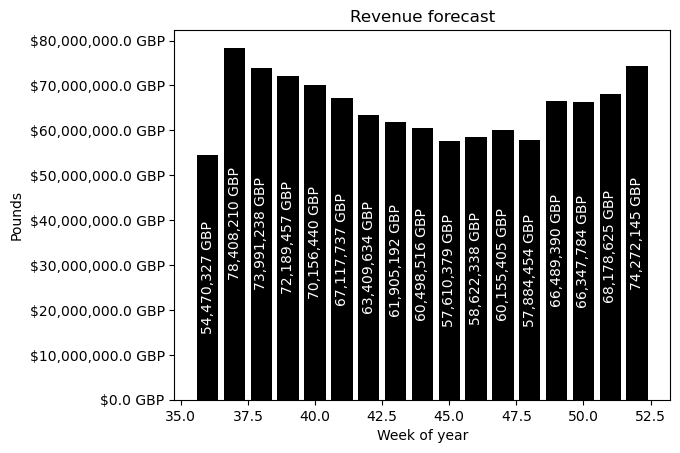

In [21]:
#Filter till year-end, listings not available (vailable == f ==>booked) 
mask = (df["date"] < "2024-01-01") & (df["available"] == "f")
df_2023 = df[mask]
# group by week number
grouped =df_2023.groupby(["year_week"],group_keys=False)
# sum prices for each week
result =grouped["price_num"].agg("sum")
total_forecasted_revenue = sum(result.values)
print("The accumulated revenue till year-end is {:,} GBP".format(int(total_forecasted_revenue)))

fig, ax = mp.subplots()

p= ax.bar(result.index, result.values, color='k')

ax.bar_label(p, fmt=lambda x: f'{int(x):,} GBP', rotation = 90, label_type='center', color='w')
ax.set_ylabel('Pounds')
ax.set_title('Revenue forecast')
ax.set_xlabel('Week of year')
ax.yaxis.set_major_formatter('${x:,} GBP')
ax.xaxis.set_major_formatter('{x:2}')
mp.show()

## 8.- For marketing department ==> Categorizing apartments by capacity (accommodates), which two categories produce the highest income till year end.

In [22]:
#Filter till year-end, listings not available (vailable == f ==>booked) 
mask = (df["date"] < "2024-01-01") & (df["available"] == "f")
df_2023 = df[mask]
# group by listing_id
grouped =df_2023.groupby(["listing_id"],group_keys=False)
# sum prices for each listing
result =grouped["price_num"].agg("sum")
# Create a summary DataFrame
revenue_by_listing = pd.DataFrame({"id": list(result.index), "pounds": list(result.values)})
# select relevant columns form listings
listing_accommodates = listings[["id","accommodates", "beds", "bedrooms"]]
# SQL left outer join
join =pd.merge(revenue_by_listing, listing_accommodates, on="id", how="left")


In [23]:
grouped=join.groupby("accommodates")
result=grouped["pounds"].agg("sum")
sorted_result = sorted(zip(result.index, result.values), key=lambda x: x[1], reverse=True)
print("Till the end of the year, listings with {} accommodates contribute the most revenue with {:,} GBP".format(sorted_result[0][0],int(sorted_result[0][1])), end="")
print(", followed by listings with {} accommodates that contribute {:,} GBP".format(sorted_result[1][0],int(sorted_result[1][1])))

Till the end of the year, listings with 2 accommodates contribute the most revenue with 292,269,006 GBP, followed by listings with 4 accommodates that contribute 274,383,850 GBP


## 9.- For marketing department ==> How listings for 2 accommodates have reported number of beds

In [24]:
# filter listings for 2 accommodates
mask_join = (join["accommodates"] == 2)
masked_join = join[mask_join]
grouped=masked_join.groupby(["beds"])
result=grouped.size()
total_listings_for_2_accommodatres = sum(result.values)

In [25]:
for i,e in enumerate(result):
    print("There are {:8,} listing of 2 accomodates reporting {} beds, it is a {:.3f}% ".format(e,i, e/total_listings_for_2_accommodatres))

There are      575 listing of 2 accomodates reporting 0 beds, it is a 0.016% 
There are   32,253 listing of 2 accomodates reporting 1 beds, it is a 0.908% 
There are        2 listing of 2 accomodates reporting 2 beds, it is a 0.000% 
There are        1 listing of 2 accomodates reporting 3 beds, it is a 0.000% 
There are    2,451 listing of 2 accomodates reporting 4 beds, it is a 0.069% 
There are      165 listing of 2 accomodates reporting 5 beds, it is a 0.005% 
There are       50 listing of 2 accomodates reporting 6 beds, it is a 0.001% 
There are       16 listing of 2 accomodates reporting 7 beds, it is a 0.000% 
There are        4 listing of 2 accomodates reporting 8 beds, it is a 0.000% 


## 10.- For Procurement department ==> On a year basis, which evolution has follow the number of listings joining Airbnb?

In [30]:
df = listings[["id","host_since", "accommodates"]]
df.loc[:,"year"] = df["host_since"].dt.isocalendar().year
grouped =df.groupby("year")
result=grouped.size()

/tmp/ipykernel_17243/2250047334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"year"] = df["host_since"].dt.isocalendar().year


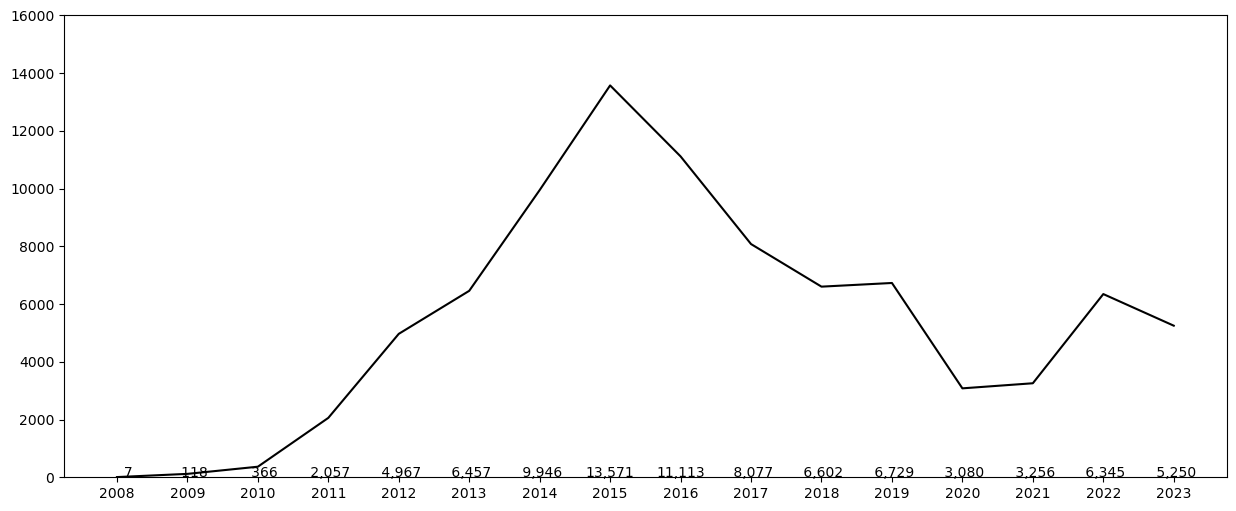

In [28]:

fig, ax = mp.subplots(figsize=(15, 6))

ax.plot(result.index, result.values, color='k')
for x,y in zip(result.index, result.values):
    label = "{:6,}".format(y)
    mp.annotate(label, # this is the text
                 (x,0), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
ax.set_ylim([0, 16000])

x_labels = range(min(result.index), max(result.index)+1)
ax.set_xticks(x_labels) 
mp.show()


# Thank you Ivanna for your time reading my code.